# Exercices

## **Préliminaires**: Clone de votre repo et imports

In [1]:
# fonctions utiles pour l'ensemble des exercices:
! git clone https://github.com/Zaidelmo/exam_2025_session2.git
! cp exam_2025_session2/utils/utils.py .
import copy
import numpy as np
import torch
import matplotlib.pyplot as plt
from utils import gen_dr, gen_d, gen_ex2, gen_dr_train,gen_dr_test, voir_batch2D, UNet, make_batch

Cloning into 'exam_2025_session2'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 81 (delta 23), reused 8 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (81/81), 312.73 KiB | 12.51 MiB/s, done.
Resolving deltas: 100% (23/23), done.


\

---

\

\

**Exercice 1** *Une segmentation dans un contexte faiblement supervisé*

La fonction *gen_dr* permet de synthétiser des disques mêlés à des rectangles. Ici, les disques sont considérés comme du bruit, et le processus de corruption non en une somme (image = image_disques + image_rectangles) mais en une substitution (voir ci-dessous).
Elle fournit aussi une cible idéale, qui, en pratique, n'est pas disponible.


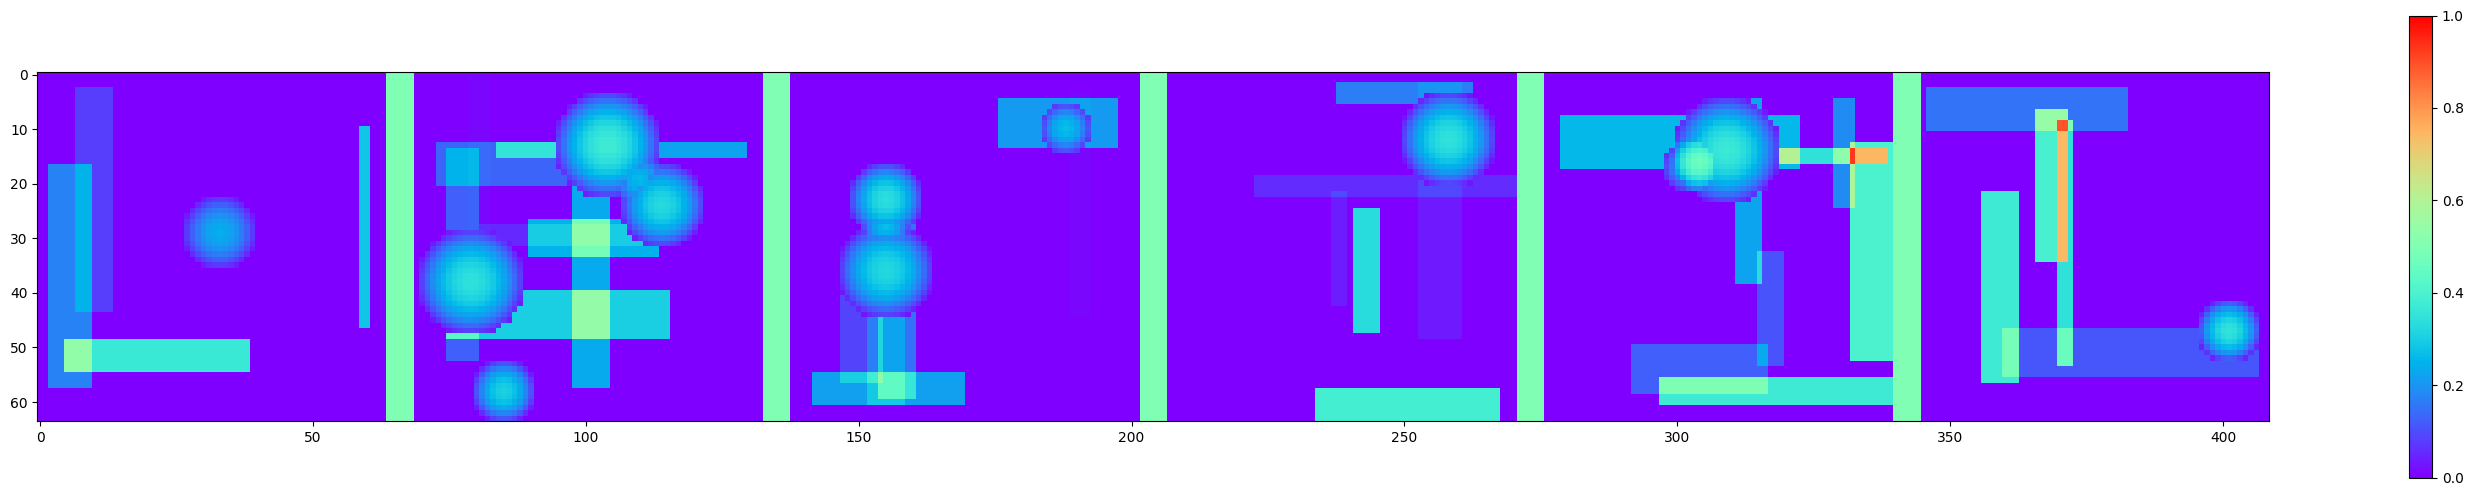

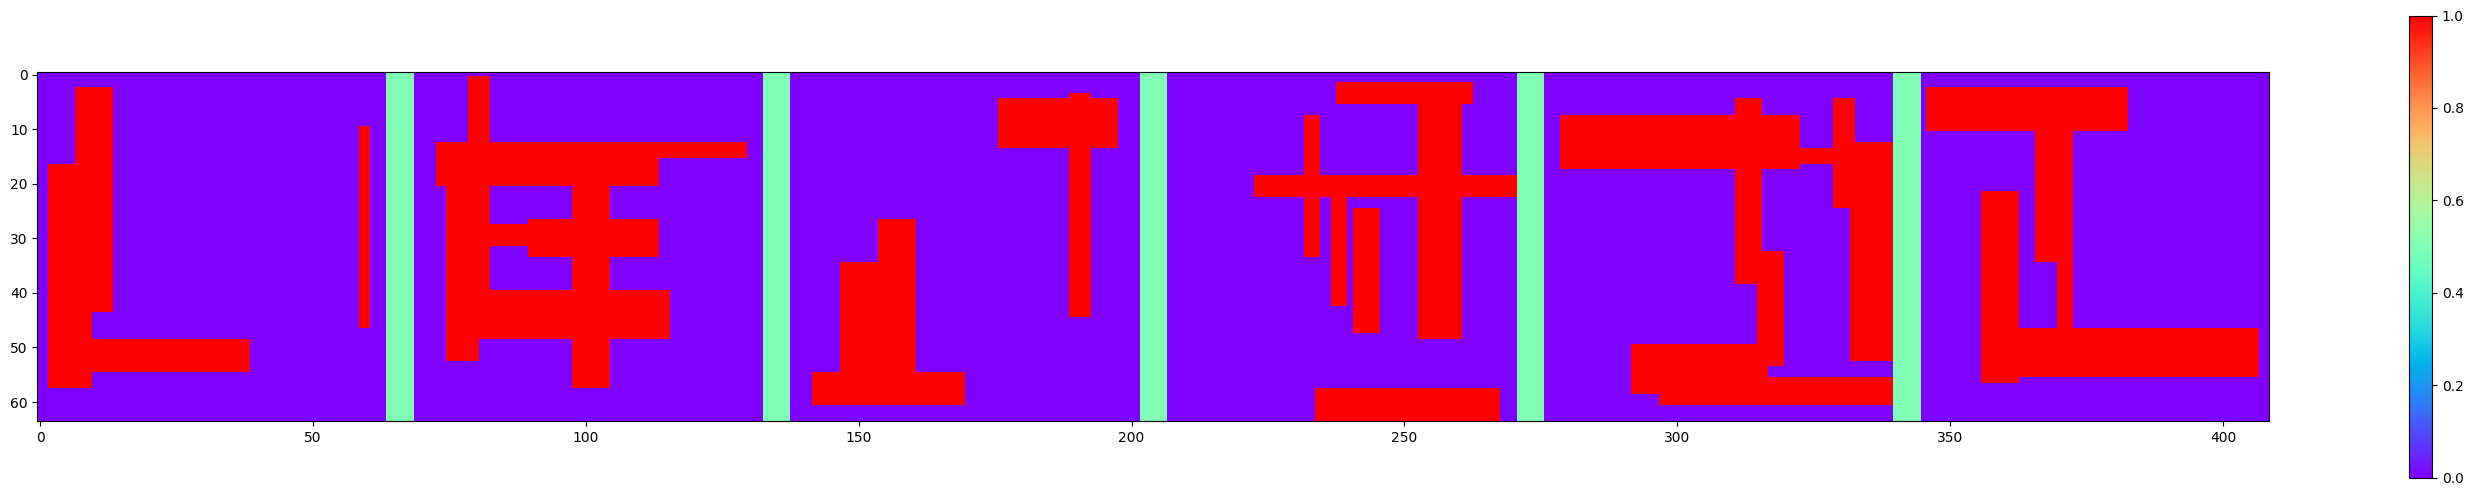

In [2]:
input, ideal_targets = gen_dr(6)
# Inputs
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# ideal targets
fig1 = plt.figure(0, figsize=(36, 6))
voir_batch2D(ideal_targets, 6, fig1, k=0, min_scale=0,max_scale=1)

On dispose aussi d'une fonction *gen_d* qui synthétise des images comportant des disques :

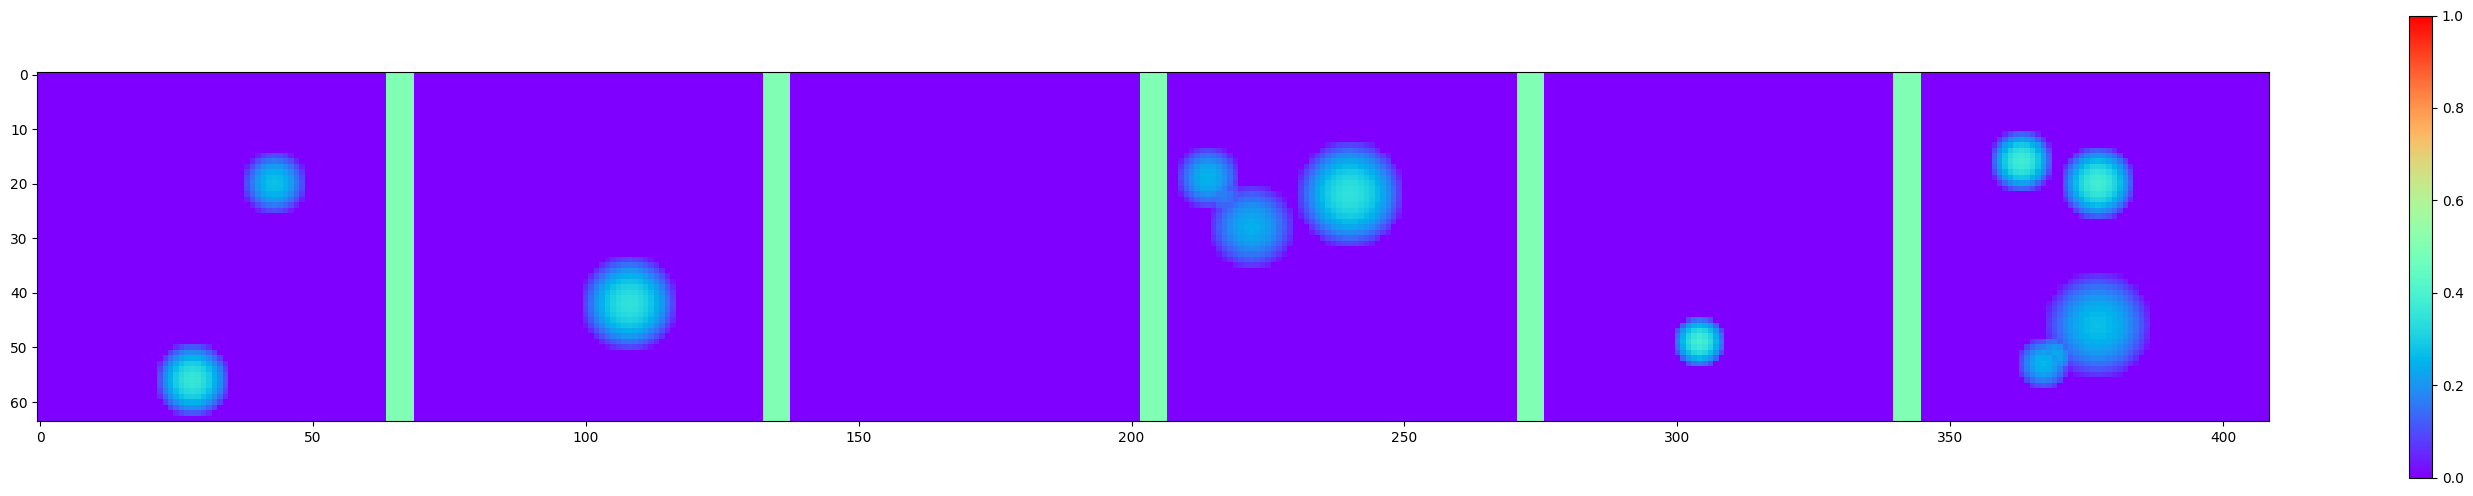

In [3]:
discs = gen_d(6)
# Discs
fig2 = plt.figure(0, figsize=(36, 6))
voir_batch2D(discs, 6, fig2, k=0, min_scale=0,max_scale=1)


**Q1** Rappeler ce qu'est la supervision faible. En quoi ce problème peut-il entrer dans cette catégorie ?

La supervision faible est une forme de supervision où l'étiquetage des données d'entrainements est grossier, incomplet ou inexistant (pour certaines données). Ce problème peut s'inscrire dans ce cadre vu que l'on entraine sur des données qui sont des images supposées "rectangulaires" mais qui réellement contiennent de la corruption.

**Q2** Utiliser un UNet pour dire, pour une image produite par gen_dr, où sont les pixels qui étaient affectés par des rectangles **avant** corruption. Entraînez-le sur une cinquantaine d'époques. Utilisez la cible idéale pour contrôler la convergence. Visualiser quelques sorties après entraînement. Commentez.

Epoch [1/50], Train Loss: 0.1938, Val Loss: 0.2295
Epoch [2/50], Train Loss: 0.0475, Val Loss: 0.4834
Epoch [3/50], Train Loss: 0.0392, Val Loss: 0.5518
Epoch [4/50], Train Loss: 0.0356, Val Loss: 0.7955
Epoch [5/50], Train Loss: 0.0267, Val Loss: 0.3854
Epoch [6/50], Train Loss: 0.0233, Val Loss: 0.2494
Epoch [7/50], Train Loss: 0.0209, Val Loss: 0.0628
Epoch [8/50], Train Loss: 0.0239, Val Loss: 0.0258
Epoch [9/50], Train Loss: 0.0218, Val Loss: 0.0279
Epoch [10/50], Train Loss: 0.0213, Val Loss: 0.0215
Epoch [11/50], Train Loss: 0.0200, Val Loss: 0.0208
Epoch [12/50], Train Loss: 0.0201, Val Loss: 0.0109
Epoch [13/50], Train Loss: 0.0164, Val Loss: 0.0141
Epoch [14/50], Train Loss: 0.0177, Val Loss: 0.0174
Epoch [15/50], Train Loss: 0.0203, Val Loss: 0.0155
Epoch [16/50], Train Loss: 0.0168, Val Loss: 0.0187
Epoch [17/50], Train Loss: 0.0155, Val Loss: 0.0183
Epoch [18/50], Train Loss: 0.0159, Val Loss: 0.0124
Epoch [19/50], Train Loss: 0.0132, Val Loss: 0.0179
Epoch [20/50], Train 

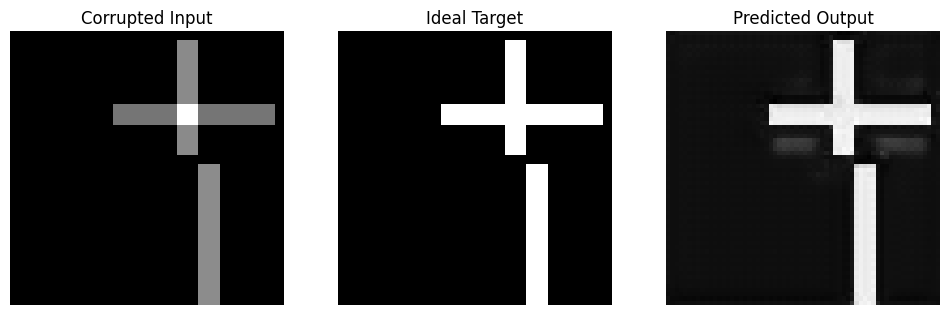

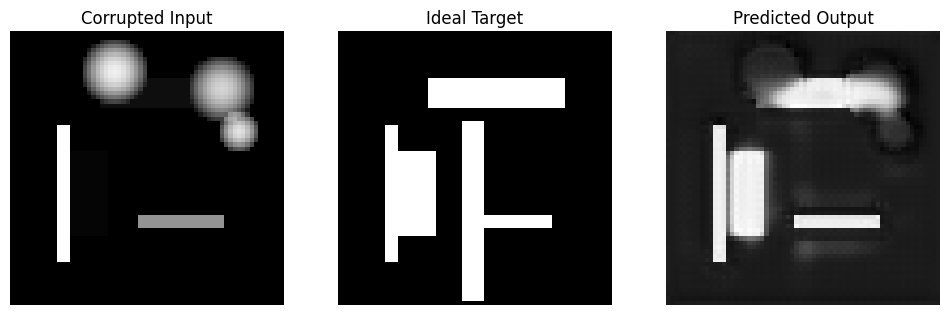

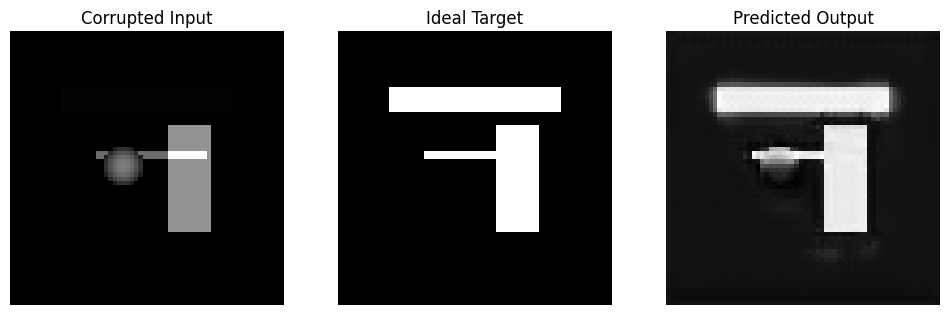

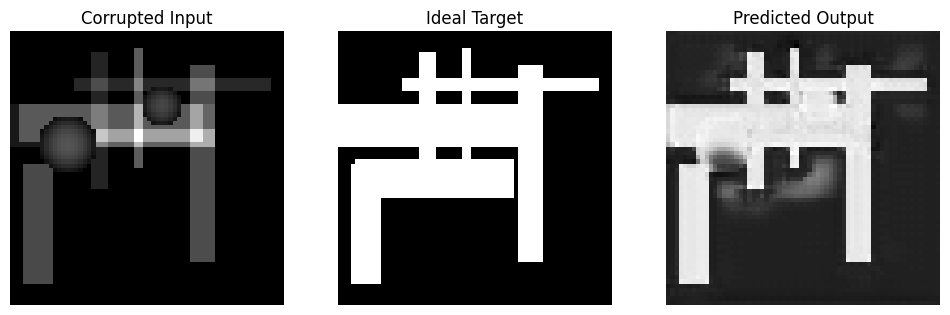

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random

# Choose which model to use:
use_calibration = False  # Set True to use UNet_cal; False to use basic UNet

if use_calibration:
    model = UNet_cal(n_channels=1, n_classes=1, size=64).cuda()
else:
    model = UNet(n_channels=1, n_classes=1, size=64).cuda()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 50
batch_size = 16
num_batches = 10  # number of mini-batches per epoch

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for _ in range(num_batches):
        # Use your provided gen_dr to generate a batch:
        rectangles, ideal_targets = gen_dr(batch_size)
        inputs = rectangles.float().cuda()
        targets = ideal_targets.float().cuda()  # ideal_targets is a boolean mask converted to float

        optimizer.zero_grad()
        if use_calibration:
            outputs, calib = model(inputs)
            loss = criterion(outputs, targets)
            # Optionally, add additional loss on 'calib' if needed.
        else:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_loss = train_loss / num_batches

    # Validation: using one batch of data to monitor convergence with ideal targets
    model.eval()
    with torch.no_grad():
        val_rectangles, val_ideal = gen_dr(batch_size)
        val_inputs = val_rectangles.float().cuda()
        val_targets = val_ideal.float().cuda()
        if use_calibration:
            val_outputs, val_calib = model(val_inputs)
            val_loss = criterion(val_outputs, val_targets)
        else:
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_targets)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Val Loss: {val_loss.item():.4f}")

# ------------------------------
# Evaluation & Visualization
# ------------------------------

model.eval()
with torch.no_grad():
    test_rectangles, test_ideal = gen_dr(4)
    test_inputs = test_rectangles.float().cuda()
    if use_calibration:
        test_outputs, test_calib = model(test_inputs)
    else:
        test_outputs = model(test_inputs)

# Move tensors to CPU and convert to numpy arrays for plotting:
test_inputs = test_inputs.cpu().numpy()
test_ideal = test_ideal.cpu().numpy()
test_outputs = test_outputs.cpu().numpy()

import matplotlib.pyplot as plt
for i in range(4):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(test_inputs[i, 0], cmap='gray')
    axs[0].set_title("Corrupted Input")
    axs[0].axis("off")

    axs[1].imshow(test_ideal[i, 0], cmap='gray')
    axs[1].set_title("Ideal Target")
    axs[1].axis("off")

    axs[2].imshow(test_outputs[i, 0], cmap='gray')
    axs[2].set_title("Predicted Output")
    axs[2].axis("off")

    plt.show()


Epoch [1/50], Train Loss: 0.8451, Val Loss: 1.4631
Epoch [2/50], Train Loss: 0.5923, Val Loss: 1.9037
Epoch [3/50], Train Loss: 0.4978, Val Loss: 2.6225
Epoch [4/50], Train Loss: 0.4221, Val Loss: 2.1344
Epoch [5/50], Train Loss: 0.3786, Val Loss: 3.2592
Epoch [6/50], Train Loss: 0.3276, Val Loss: 0.7089
Epoch [7/50], Train Loss: 0.3065, Val Loss: 0.5043
Epoch [8/50], Train Loss: 0.3043, Val Loss: 0.2782
Epoch [9/50], Train Loss: 0.2720, Val Loss: 0.3116
Epoch [10/50], Train Loss: 0.2462, Val Loss: 0.2884
Epoch [11/50], Train Loss: 0.2601, Val Loss: 0.2505
Epoch [12/50], Train Loss: 0.2562, Val Loss: 0.2175
Epoch [13/50], Train Loss: 0.2619, Val Loss: 0.2501
Epoch [14/50], Train Loss: 0.2594, Val Loss: 0.2254
Epoch [15/50], Train Loss: 0.2349, Val Loss: 0.2427
Epoch [16/50], Train Loss: 0.2347, Val Loss: 0.2204
Epoch [17/50], Train Loss: 0.2634, Val Loss: 0.2376
Epoch [18/50], Train Loss: 0.2679, Val Loss: 0.2930
Epoch [19/50], Train Loss: 0.2356, Val Loss: 0.2513
Epoch [20/50], Train 

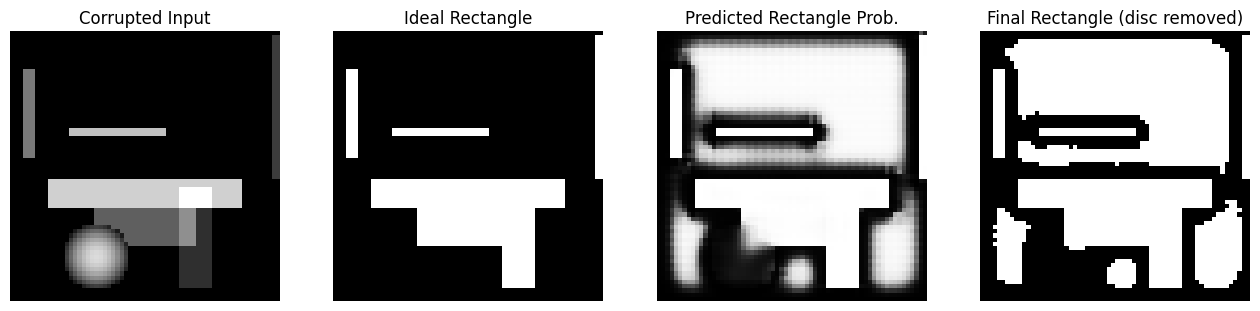

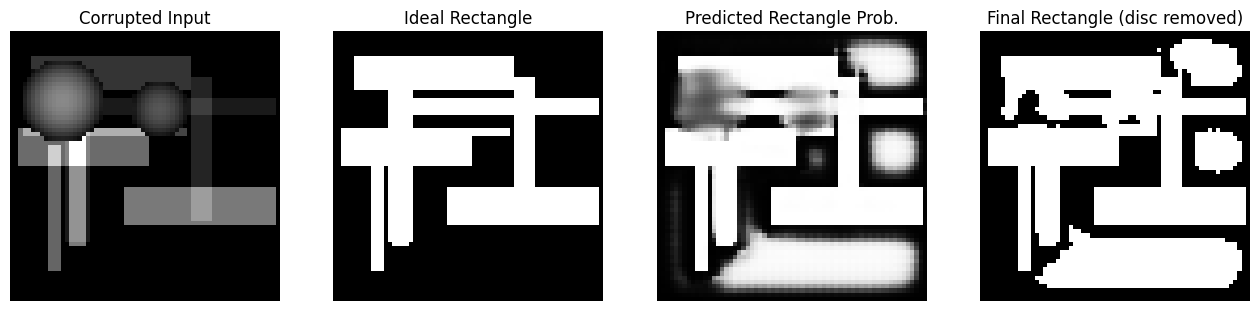

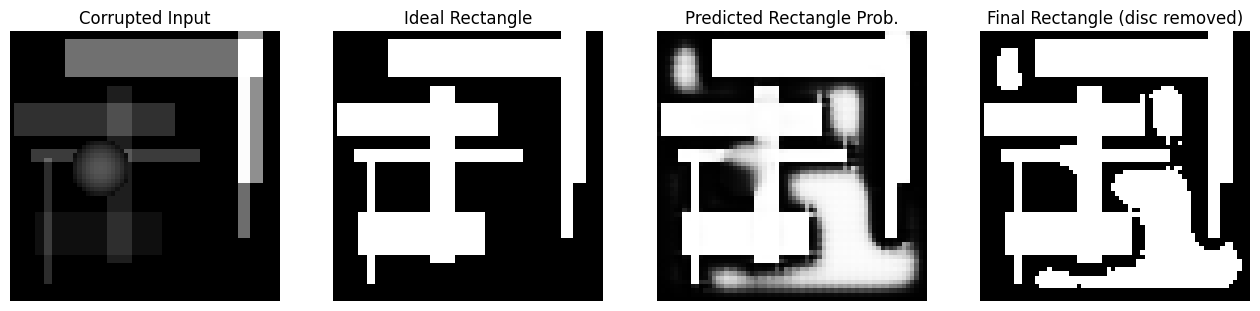

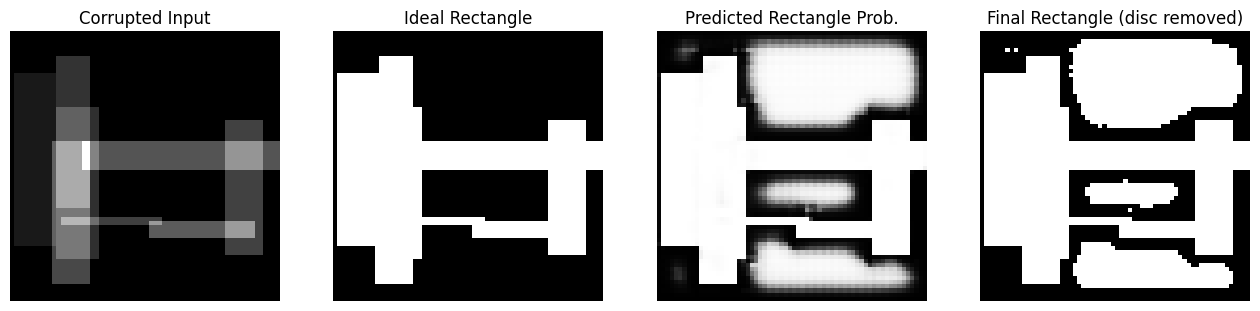

Mean IoU: 0.5508641004562378


In [20]:
def compute_iou(pred, target, smooth=1e-6):
    """
    Compute the Intersection over Union (IoU) between predicted and target masks.
    Both pred and target should be binary masks of shape [B, 1, H, W].
    """
    # Ensure binary masks (they should already be, but for safety)
    pred_bin = (pred > 0.5).float()
    target_bin = (target > 0.5).float()

    intersection = (pred_bin * target_bin).sum()
    union = pred_bin.sum() + target_bin.sum() - intersection
    return (intersection + smooth) / (union + smooth)


# --- Multi-Task Training Loop ---

# We assume the UNet definition has not changed.
# Set the network to output 2 channels: channel 0 for rectangles, channel 1 for discs.
model = UNet(n_channels=1, n_classes=2, size=64).cuda()

# For binary segmentation tasks, BCEWithLogitsLoss is more appropriate.
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 50
batch_size = 16
num_batches = 10  # Number of mini-batches per epoch

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for _ in range(num_batches):
        # Generate a batch for rectangle segmentation:
        # corrupted_rect: corrupted image with discs applied to rectangles
        # rect_ideal: ideal (clean) rectangle mask (boolean)
        corrupted_rect, rect_ideal = gen_dr(batch_size)

        # Generate a batch for discs segmentation using gen_d:
        disc_images = gen_d(batch_size)
        # Convert disc images into a binary mask (thresholding > 0)
        disc_ideal = (disc_images > 0).float()

        # Prepare inputs and targets (converted to float)
        inputs = corrupted_rect.float().cuda()  # Input image (with corruption)
        rect_target = rect_ideal.float().cuda()   # Ideal rectangle mask
        disc_target = disc_ideal.cuda()             # Ideal disc mask

        optimizer.zero_grad()
        outputs = model(inputs)  # Expected output shape: (B, 2, H, W)

        # Separate the network's outputs into rectangle and disc predictions while preserving channel dimension:
        rect_out = outputs[:, 0:1, :, :]  # shape: (B, 1, H, W)
        disc_out = outputs[:, 1:2, :, :]    # shape: (B, 1, H, W)

        # Compute separate losses for each task:
        loss_rect = criterion(rect_out, rect_target)
        loss_disc = criterion(disc_out, disc_target)

        # Combine the losses (you could weight these differently if desired)
        loss = loss_rect + loss_disc

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / num_batches

    # Validation: similar multi-task supervision on a single batch.
    model.eval()
    with torch.no_grad():
        val_corrupted, val_rect_ideal = gen_dr(batch_size)
        val_disc_images = gen_d(batch_size)
        val_disc_ideal = (val_disc_images > 0).float()

        val_inputs = val_corrupted.float().cuda()
        val_rect_target = val_rect_ideal.float().cuda()
        val_disc_target = val_disc_ideal.cuda()

        val_outputs = model(val_inputs)
        val_rect_out = val_outputs[:, 0:1, :, :]
        val_disc_out = val_outputs[:, 1:2, :, :]

        val_loss_rect = criterion(val_rect_out, val_rect_target)
        val_loss_disc = criterion(val_disc_out, val_disc_target)
        val_loss = val_loss_rect + val_loss_disc

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss.item():.4f}")

# --- Evaluation & Combining Predictions ---

model.eval()
with torch.no_grad():
    test_corrupted, test_rect_ideal = gen_dr(4)
    test_disc_images = gen_d(4)

    test_inputs = test_corrupted.float().cuda()
    test_outputs = model(test_inputs)

    # Separate outputs for rectangles and discs.
    test_rect_out = test_outputs[:, 0:1, :, :]
    test_disc_out = test_outputs[:, 1:2, :, :]

    # Apply sigmoid to get probabilities.
    test_rect_prob = torch.sigmoid(test_rect_out)
    test_disc_prob = torch.sigmoid(test_disc_out)

    # For a final prediction you might want to "remove" disc areas from the rectangle prediction.
    # For example, using a threshold of 0.5 on each:
    #alpha = 0.7  # weight for the rectangle confidence
    #final_rect_prob = alpha * test_rect_prob + (1 - alpha) * (1 - test_disc_prob)
    #final_rect = (final_rect_prob > 0.5).float()
    final_rect = ((test_rect_prob > 0.5) | ((test_rect_prob - test_disc_prob) > 0.3)).float()

    # Move tensors to CPU for visualization.
    test_inputs_np = test_inputs.cpu().numpy()
    test_rect_ideal_np = test_rect_ideal.cpu().numpy()
    final_rect_np = final_rect.cpu().numpy()
import matplotlib.pyplot as plt
for i in range(4):
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    axs[0].imshow(test_inputs_np[i, 0], cmap='gray')
    axs[0].set_title("Corrupted Input")
    axs[0].axis("off")

    axs[1].imshow(test_rect_ideal_np[i, 0], cmap='gray')
    axs[1].set_title("Ideal Rectangle")
    axs[1].axis("off")

    # Optionally, display the raw predicted rectangle probabilities.
    axs[2].imshow(test_rect_prob.cpu().numpy()[i, 0], cmap='gray')
    axs[2].set_title("Predicted Rectangle Prob.")
    axs[2].axis("off")

    axs[3].imshow(final_rect_np[i, 0], cmap='gray')
    axs[3].set_title("Final Rectangle (disc removed)")
    axs[3].axis("off")

    plt.show()
final_rect_cpu = final_rect.cpu()
ideal_cpu = test_rect_ideal.float().cpu()
iou_score = compute_iou(final_rect_cpu, ideal_cpu)
print("Mean IoU:", iou_score.item())

J'ai essayé deux approches différentes: Sur la premiere approche, on utilise une segmentation simple pour detecter les rectangles avec une MSE comme fonction de loss, le resultat en terme d'erreurs etait satisfaisant mais les

\

**Exercice 2** *Une régression quantile*

La fonction *gen_ex2* permet de synthétiser des entrées / cibles à la volée :  




In [ ]:
# sampling (x,y) :

inputs, targets = gen_ex2(6)
# Inputs
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(inputs, 6, fig0, k=0, min_scale=0,max_scale=1)

# Targets
print(targets)

**Q1** Définir un Loader à partir du Dataset précédent (2 workers)

**Q2** Entraîner un ResNet18 à prédire la médiane conditionnelle à l'image d'entrée. Justifier l'absence d'une étape de validation.

In [ ]:
from torchvision.models import resnet18

...

**Q3** Modifier votre ResNet18 de manière à prédire aussi les premier et troisième quartiles. Préciser le nom de la fonction de coût utilisée.

**Q4** Après entraînement, évaluer les écarts interquartiles sur un batch de taille 64. Ces écarts semblent-ils dépendre de l'image d'entrée ?

**Q5 (Bonus)** On fait l'hypothèse que la sortie ne dépend que des disques. On suppose aussi qu'on ait accès, comme à l'exercice 1 à un jeu de données d'images ne comportant que des disques (fonction gen_d). Que feriez-vous pour tester cette hypothèse ? Répondez sans code, mais avec précision.

\

---

\

**Exercice 3** *Nettoyage et adaptation de domaine*

Comme à l'exercice 1, les disques sont considérés comme du bruit. Mais par contre, il s'agit d'une tâche de nettoyage et on se place dans le cas où des entrées et des cibles idéales sont disponibles en grand nombre à l'entraînement (fonction *gen_dr_train*).

In [ ]:
input, targets = gen_dr_train(6)
# Inputs (train)
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# targets (train)
fig1 = plt.figure(0, figsize=(36, 6))
voir_batch2D(targets, 6, fig1, k=0, min_scale=0,max_scale=1)

Par contre, on suppose que les images disponibles à l'entraînement ne suivent pas les mêmes statistiques que les données test, échantillonnables avec la fonction gen_dr_test suivante :

In [ ]:
input, targets = gen_dr_test(6)
# Inputs (test)
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# targets (test)
fig1 = plt.figure(0, figsize=(36, 6))
voir_batch2D(targets, 6, fig1, k=0, min_scale=0,max_scale=1)

Ce qu'on voit en effet, c'est que les images test sont plus chargées en figures géométriques. \
Dans la réalité, ce cas de figure se présente lorsque :
 - les données propres au test (ie, représentatives des données à traiter en inférence) sont en trop petit nombre pour être exploitées à l'entraînement
 - un large jeu de données dont les statistiques sont différentes de celles des données d'inférence est disponible.

**Q1** A l'aide d'internet, décrire ce que recouvre le mot clef "domain adaptation" et faites le lien avec l'énoncé.

**Q2** Sur des entraînements courts (20 - 40 époques) avec des UNet, évaluer l'impact sur les performances sur le jeu de test lorsque les données sont entraînées avec gen_dr_train plutôt que dans une situation idéale.

**Q3 (Bonus)** Proposez une méthode simple pour améliorer les performances.

\

---

\

**Exercice 4** Un article important

Parcourir rapidement l'article : https://arxiv.org/abs/1505.04597.
Préciser :
- la nature du problème de Machine Learning abordé.
- quelles méthodes d'augmentation de données sont utilisées.
- l'origine du déséquilibre entre les classes cibles et la façon dont elle il est traité (de manière synthétique).